In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import torch
from jax import random
from jaxtyping import Array, Float
from numpyro.contrib.control_flow import scan
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.reparam import LocScaleReparam
from pyro.contrib.examples.bart import load_bart_od
from pyro.ops.tensor_utils import periodic_repeat

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

In [2]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


In [3]:
T, O, D = dataset["counts"].shape
data = dataset["counts"][:, :, dataset["stations"].index("EMBR")].log1p()
print(data.shape)

torch.Size([78888, 50])


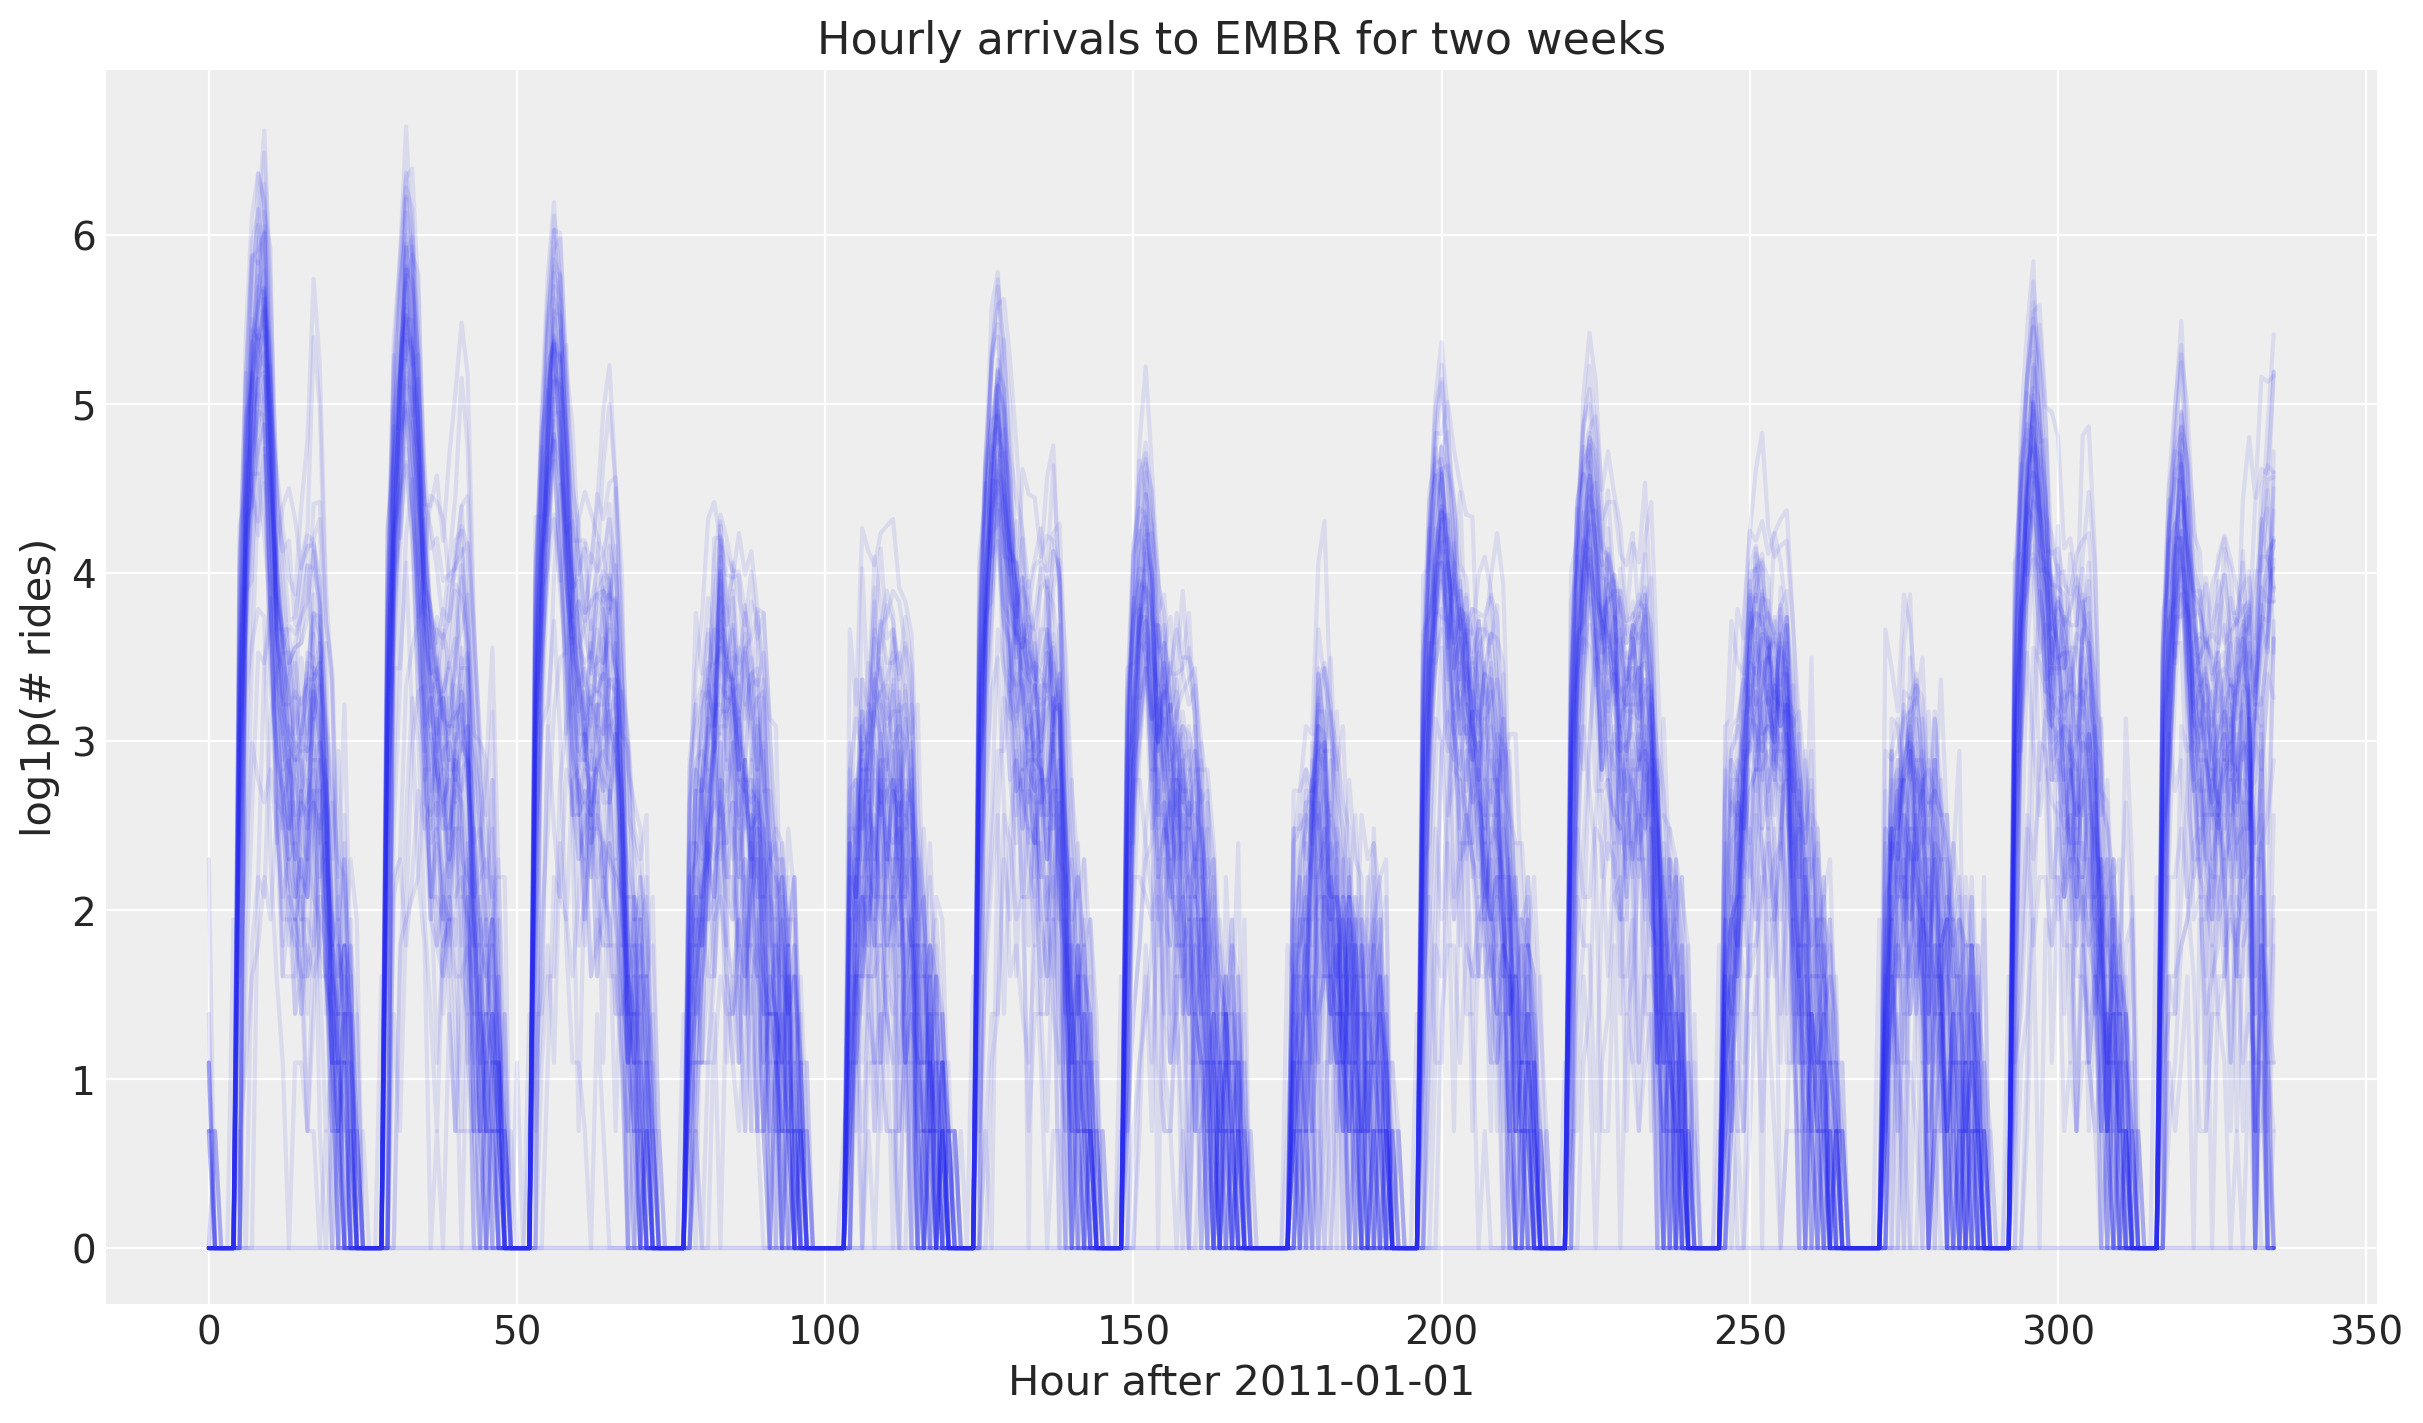

In [4]:
fig, ax = plt.subplots()
ax.plot(data[-24 * 7 * 2 :], "-", c="C0", alpha=0.1, markeredgewidth=0)
ax.set(
    title="Hourly arrivals to EMBR for two weeks",
    ylabel="log1p(# rides)",
    xlabel="Hour after 2011-01-01",
);

In [5]:
T2 = data.size(-2)  # end
T1 = T2 - 24 * 7 * 2  # train/test split
T0 = T1 - 24 * 90  # beginning: train on 90 days of data

In [6]:
y = jnp.array(data[T0:T2])
y_train = jnp.array(data[T0:T1])
y_test = jnp.array(data[T1:T2])

print(f"y: {y.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

y: (2496, 50)
y_train: (2160, 50)
y_test: (336, 50)


In [7]:
n_stations = y_train.shape[-1]

time = jnp.array(range(T0, T2))
time_train = jnp.array(range(T0, T1))
t_max_train = time_train.size

time_test = jnp.array(range(T1, T2))
t_max_test = time_test.size

assert time_train.size + time_test.size == time.size
assert y_train.shape == (t_max_train, n_stations)
assert y_test.shape == (t_max_test, n_stations)

In [8]:
covariates = jnp.zeros_like(y)
covariates_train = jnp.zeros_like(y_train)
covariates_test = jnp.zeros_like(y_test)

In [9]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])

periodic_repeat(x, 4, 0)

tensor([[1, 2, 3],
        [4, 5, 6],
        [1, 2, 3],
        [4, 5, 6]])

In [10]:
periodic_repeat(x, 4, 1)

tensor([[1, 2, 3, 1],
        [4, 5, 6, 4]])

In [11]:
def periodic_repeat_jax(tensor, size, dim):
    """
    Repeat a period-sized tensor up to given size using JAX.

    Parameters
    ----------
    tensor : jnp.ndarray
        A JAX array to be repeated.
    size : int
        Desired size of the result along dimension `dim`.
    dim : int
        The tensor dimension along which to repeat.

    Returns
    -------
    jnp.ndarray
        The repeated tensor.
    """
    assert isinstance(size, int) and size >= 0
    assert isinstance(dim, int)
    if dim >= 0:
        dim -= tensor.ndim

    period = tensor.shape[dim]
    repeats = [1] * tensor.ndim
    repeats[dim] = (size + period - 1) // period
    result = jnp.tile(tensor, repeats)

    slices = [slice(None)] * tensor.ndim
    slices[dim] = slice(None, size)

    return result[tuple(slices)]

In [12]:
assert jnp.allclose(
    periodic_repeat_jax(jnp.array(x), 4, 0), jnp.array(periodic_repeat(x, 4, 0))
)

assert jnp.allclose(
    periodic_repeat_jax(jnp.array(x), 4, 1), jnp.array(periodic_repeat(x, 4, 1))
)

In [13]:
def model(
    covariates: Float[Array, "t_max n_series"],
    y: Float[Array, "t_max n_series"] | None = None,
) -> None:
    t_max, n_series = covariates.shape
    # Get the time and feature dimensions

    # Global scale for the drift
    drift_scale = numpyro.sample("drift_scale", dist.LogNormal(loc=-20, scale=5))

    # Scale for the Student-T distribution
    sigma = numpyro.sample("sigma", dist.LogNormal(loc=-5, scale=5))

    centered = numpyro.sample("centered", dist.Uniform(low=0, high=1))

    with numpyro.plate("n_series", n_series):
        with (
            numpyro.plate("time", t_max),
            numpyro.handlers.reparam(
                config={"drift": LocScaleReparam(centered=centered)}
            ),
        ):
            drift = numpyro.sample("drift", dist.Normal(loc=0, scale=drift_scale))

        with numpyro.plate("hour_of_week", 24 * 7):
            seasonal = numpyro.sample("seasonal", dist.Normal(loc=0, scale=5))

    seasonal_repeat = periodic_repeat_jax(seasonal, t_max, 0)

    def transition_fn(carry, t):
        "Local level transition function"
        previous_level = carry
        current_level = previous_level + drift[t]
        return current_level, current_level

    # Compute the latent levels using scan
    _, pred_levels = scan(
        transition_fn, init=jnp.zeros((n_series,)), xs=jnp.arange(t_max)
    )

    # Compute the mean of the model
    mu = pred_levels + seasonal_repeat

    # Sample the observations
    with numpyro.handlers.condition(data={"obs": y}):
        numpyro.sample("obs", dist.Normal(loc=mu, scale=sigma))

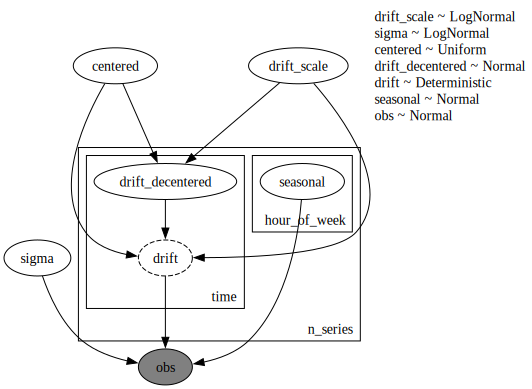

In [14]:
numpyro.render_model(
    model=model,
    model_kwargs={"covariates": covariates_train, "y": y_train},
    render_distributions=True,
    render_params=True,
)

In [15]:
prior_predictive = Predictive(model=model, num_samples=2_000, return_sites=["obs"])

rng_key, rng_subkey = random.split(rng_key)

prior_samples = prior_predictive(rng_subkey, covariates_train)

idata_prior = az.from_dict(
    prior_predictive={k: v[None, ...] for k, v in prior_samples.items()},
    coords={"time_train": time_train, "n_series": jnp.arange(n_stations)},
    dims={"obs": ["time_train", "n_series"]},
)

In [16]:
idata_prior

Inference data with groups:
	> prior_predictive

100%|██████████| 20000/20000 [00:56<00:00, 357.08it/s, init loss: 81283016.0000, avg. loss [19001-20000]: 97516.8763] 


CPU times: user 1min 44s, sys: 46.9 s, total: 2min 31s
Wall time: 58.9 s


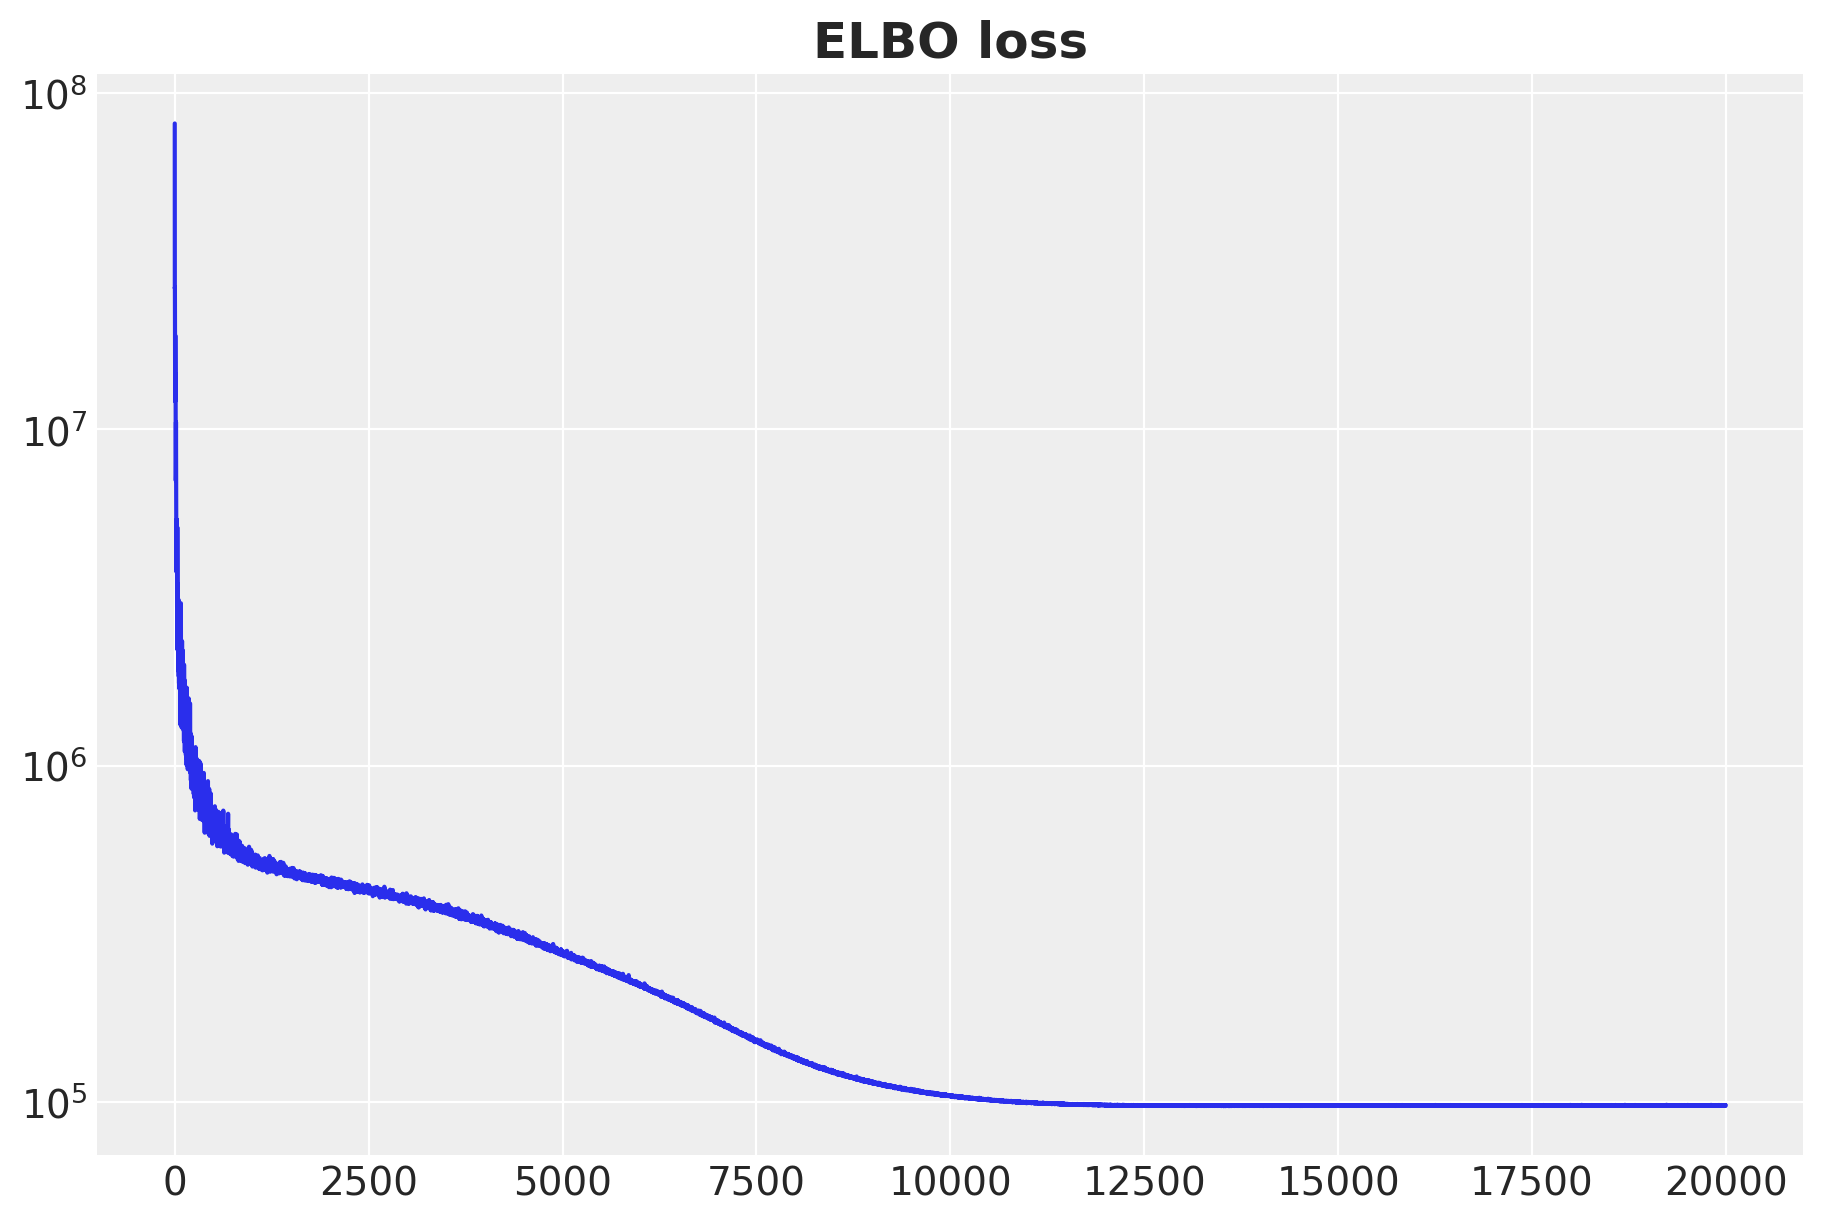

In [17]:
%%time

guide = AutoNormal(model)
optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
num_steps = 20_000

rng_key, rng_subkey = random.split(key=rng_key)

svi_result = svi.run(
    rng_subkey,
    num_steps,
    covariates_train,
    y_train,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_yscale("log")
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

In [18]:
posterior = Predictive(
    model=model,
    guide=guide,
    params=svi_result.params,
    num_samples=2_000,
    return_sites=["obs"],
)

In [19]:
rng_key, rng_subkey = random.split(rng_key)

idata_train = az.from_dict(
    posterior_predictive={
        k: v[None, ...] for k, v in posterior(rng_subkey, covariates_train).items()
    },
    coords={"time_train": time_train, "n_series": jnp.arange(n_stations)},
    dims={"obs": ["time_train", "n_series"]},
)

idata_test = az.from_dict(
    posterior_predictive={
        k: v[None, ...] for k, v in posterior(rng_subkey, covariates).items()
    },
    coords={"time": time, "n_series": jnp.arange(n_stations)},
    dims={"obs": ["time", "n_series"]},
)

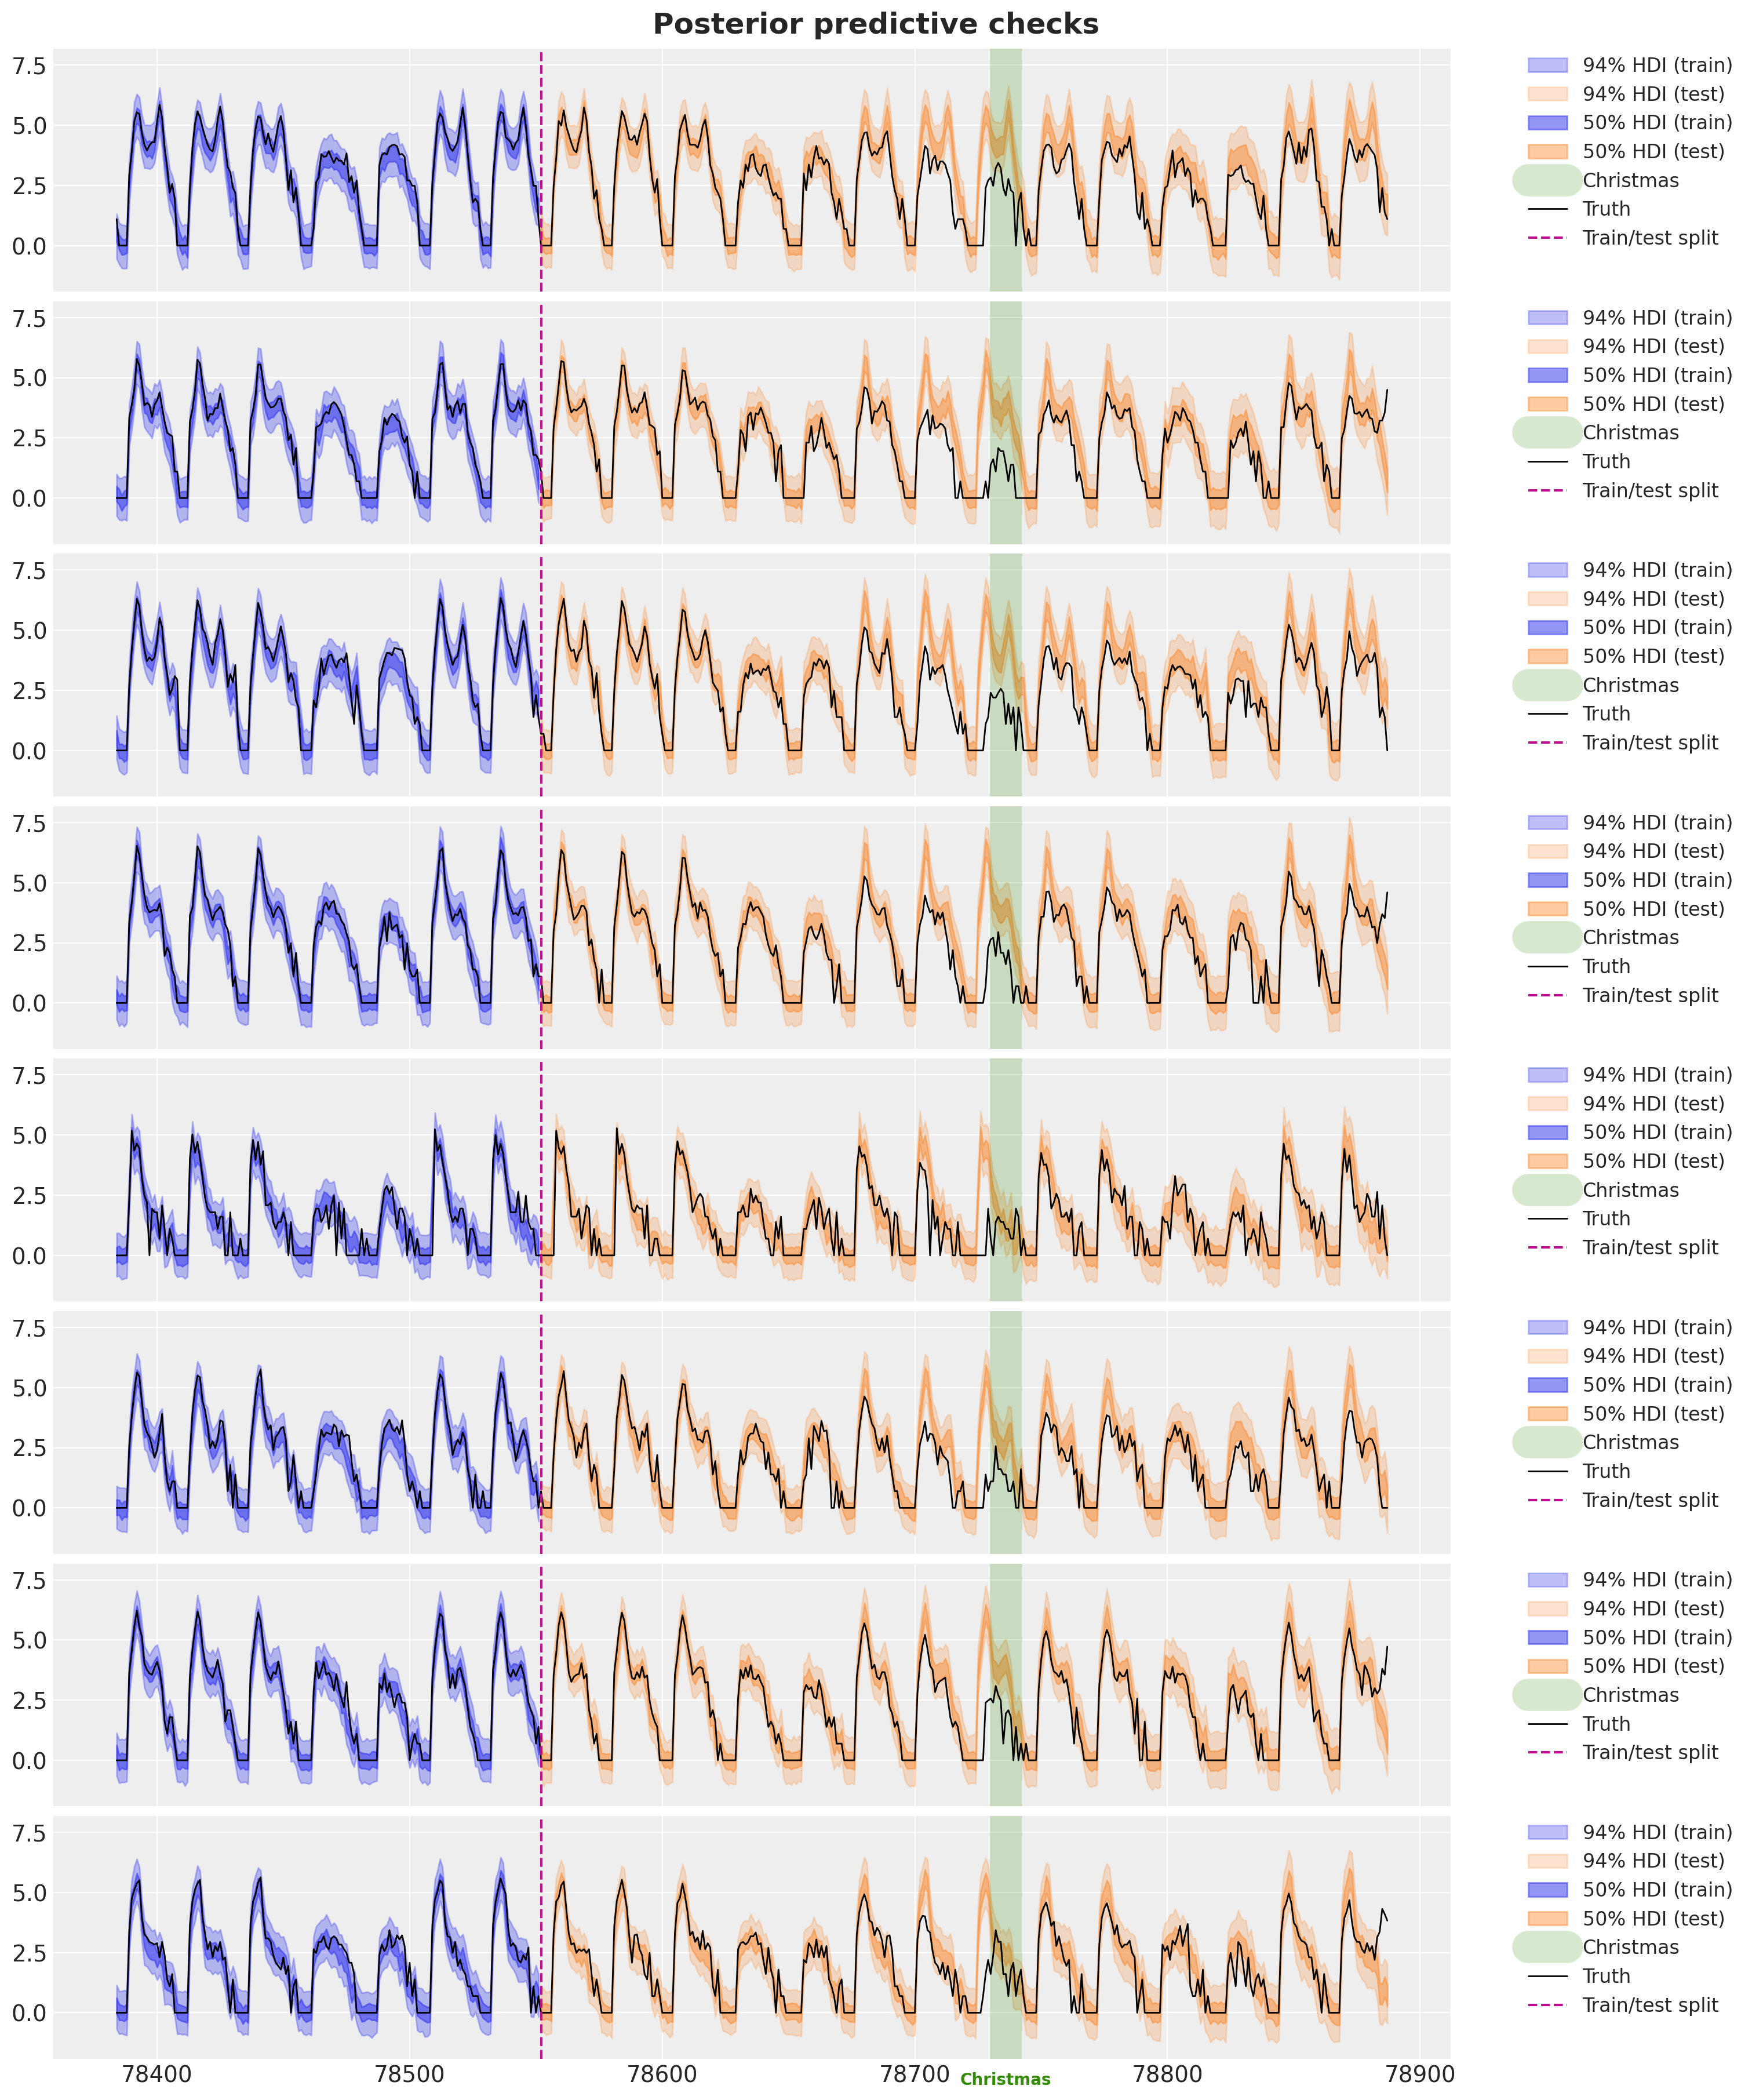

In [29]:
christmas_index = 78736

fig, axes = plt.subplots(
    nrows=8, ncols=1, figsize=(15, 18), sharex=True, sharey=True, layout="constrained"
)
for i, ax in enumerate(axes):
    for j, hdi_prob in enumerate([0.94, 0.5]):
        az.plot_hdi(
            time_train[time_train >= T1 - 24 * 7],
            idata_train["posterior_predictive"]["obs"].sel(n_series=i)[
                :, :, time_train >= T1 - 24 * 7
            ],
            hdi_prob=hdi_prob,
            color="C0",
            fill_kwargs={
                "alpha": 0.3 + 0.2 * j,
                "label": f"{hdi_prob*100:.0f}% HDI (train)",
            },
            smooth=False,
            ax=ax,
        )
        az.plot_hdi(
            time[time >= T1],
            idata_test["posterior_predictive"]["obs"].sel(n_series=i)[:, :, time >= T1],
            hdi_prob=hdi_prob,
            color="C1",
            fill_kwargs={
                "alpha": 0.2 + 0.2 * j,
                "label": f"{hdi_prob*100:.0f}% HDI (test)",
            },
            smooth=False,
            ax=ax,
        )
    ax.axvline(christmas_index, color="C2", lw=20, alpha=0.2, label="Christmas")
    ax.plot(
        time[time >= T1 - 24 * 7],
        data[T1 - 24 * 7 : T2, i],
        "black",
        lw=1,
        label="Truth",
    )
    ax.axvline(T1, color="C3", linestyle="--", label="Train/test split")

    ax.legend(
        bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, fontsize=12
    )

ax.text(
    christmas_index,
    -3,
    "Christmas",
    color="C2",
    fontsize=10,
    fontweight="bold",
    horizontalalignment="center",
)

fig.suptitle("Posterior predictive checks", fontsize=18, fontweight="bold");